\begin{align*}
f(\beta_0, \beta) &= \frac{1}{2N} \sum_{i=1}^N \left(y_i - \beta_0 - x_i^T \beta \right)^2 + \lambda P_\alpha(\beta) \\
\frac{\partial f}{\partial \beta_0} &= 
-\frac{1}{N} \sum_{i=1}^N \left(y_i - \beta_0 - x_i^T \beta \right) \\
\beta_0^*(\beta) &= \frac{1}{N} \sum_{i=1}^N \left(y_i - x_i^T \beta \right)
\end{align*}

If $\beta_j = 0$, the gradient is not defined. If $\beta_j \neq 0$, then
\begin{align*}
\frac{\partial f}{\partial \beta_j} &= 
\frac{-1}{N} \sum_i x_{ij} \left(y_i - \beta_0 - x_i^T \beta \right) 
+ \lambda \frac{\partial P_\alpha(\beta)}{\partial \beta_j} \\
&= 
\frac{-1}{N} \sum_i x_{ij} \left(y_i - \beta_0 - x_i^T \beta \right) 
+ \lambda \left( (1 - \alpha) \beta_j + \alpha \mathrm{sign}(\beta_j)
\right)
\end{align*}

The optimal $\beta_j$ will be zero if the gradient to the right of 0 is negative and the gradient to right is positive. That is,
\begin{align*}
- \lambda \alpha &> \frac{1}{N} \sum_i x_{ij} \left(y_i - \beta_0 - x_i^T \beta \right) > \lambda \alpha \\
\mathrm{abs} \left( \frac{1}{N} \sum_i x_{ij} \left(y_i - \beta_0 - x_i^T \beta \right) \right)  &< \lambda \alpha
\end{align*}

When the optimal value of $\beta_j$ is not zero, we can find it by setting the gradient equal to zero:
\begin{align*}
0 &= 
\frac{-1}{N} \sum_i x_{ij} \left(
y_i - \beta_0 - \tilde{x}^T_{ij} \tilde{\beta}_j - x_{ij} \beta_j \right)
+ \lambda \left( (1 - \alpha) \beta_j + \alpha \mathrm{sign}(\beta_j) \right) \\
\beta_j \left( \frac{1}{N} \sum_i x_{ij}^2 + \lambda(1 - \alpha) \right) &= 
\frac{-1}{N} \sum_i x_{ij} \left(
y_i - \beta_0 - \tilde{x}^T_{ij} \tilde{\beta}_j \right)
- \lambda \alpha \mathrm{sign}(\beta_j) \\
\beta_j^*  &= 
\frac{\frac{1}{N} \sum_i x_{ij} \left(
y_i - \beta_0 - \tilde{x}^T_{ij} \tilde{\beta}_j \right)
- \lambda \alpha \mathrm{sign}(\beta_j) }
{\frac{1}{N} \sum_i x_{ij}^2 
+ \lambda (1 - \alpha) }
\end{align*}

## Naive Updates (Section 2.1)

\begin{align*}
\end{align*}

Using the soft-thresholding operator
\begin{align*}
\beta_j^*  &= \frac
{S \left( \frac{1}{N} \sum_i x_{ij} \left(y_i - \beta_0 - \tilde{x}_{ij}^T \tilde{\beta}_j \right), \lambda \alpha \right)}
{\frac{1}{N} \sum_i x_{ij}^2 + \lambda (1 - \alpha) }
\end{align*}
In the "naive" optimizer, $x$ is normalized so that $\frac{1}{N}\sum_i x_{ij}^2 = 1$. In the sparse optimizer, it is not so clear what is going on, but I think $x$ is scaled so that the same property still holds.

Let
$z = \frac{1}{N} \sum_i x_{ij} (y_i - \beta_0 - \tilde{x}_{ij}^T \tilde{\beta}_j)$. Let's look at $z$ more closely, defining residuals $r$.
\begin{align*}
z &= \frac{1}{N}  \sum_i x_{ij} (y_i - \beta_0 - \tilde{x}_{ij}^T \tilde{\beta}_j) \\
&= \frac{1}{N} \sum_i x_{ij} (r_i + x_{ij} \beta_j)\\
&= \frac{1}{N} \sum_i x_{ij} r_i + \frac{1}{N} \beta_j \sum_i x_{ij}^2
\end{align*}

If we have normalized so that $\frac{1}{N} \sum_i x_{ij}^2 = 1$, then we can simplify the above equations:
\begin{align*}
z &= \frac{1}{N} \sum_i x_{ij} r_i + \beta_j \\
\beta_j^* &= \frac{S(z, \lambda \alpha)}{1 + \lambda (1 - \alpha)}
\end{align*}

In [122]:
def get_cw_update(y, x, j, beta, alpha, lambda_):
    prediction_not_j = x.dot(beta) - x[:, j] * beta[j]
    resid = y - prediction_not_j
    n = len(y)
    mean_resid = x[:, j].dot(resid) / n
    numerator = soft_threshold(mean_resid, lambda_ * alpha)
    denominator = 1 + lambda_ * (1 - alpha)
    return numerator / denominator

In [123]:
def cd_update(y, x, beta, alpha, lamba_):
    for i in range(len(beta)):
        beta[i] = get_cw_update(y, x, j, beta, alpha, lambda_)
    return beta

In [124]:
def do_cd(y, x, alpha, lambda_, n_iters):
    beta = np.zeros(x.shape[1])
    for i in range(n_iters):
        beta = cd_update(y, x, beta, alpha, lambda_)
    return beta

In [106]:
min_vals = results[results['obj'] == results['obj'].min()]
min_vals

,b1,b2,obj
2470,0,50,1.5
2589,1,49,1.5
2708,2,48,1.5
2827,3,47,1.5
2946,4,46,1.5
3065,5,45,1.5
3184,6,44,1.5
3303,7,43,1.5
3422,8,42,1.5
3541,9,41,1.5


[Text(0, 0, '-20.0'),
 Text(0, 0, '0.0'),
 Text(0, 0, '20.0'),
 Text(0, 0, '40.0'),
 Text(0, 0, '60.0'),
 Text(0, 0, '80.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '120.0')]

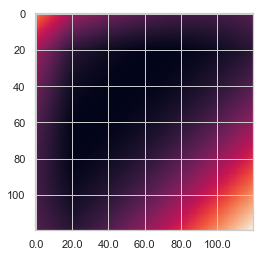

In [118]:
fig, ax = plt.subplots()
ax.imshow(
    results.set_index(['b2', 'b1'])['obj'].unstack()
)
#ax.set_xticks(range(-20, 120, 30))
ax.set_xticklabels(ax.get_xticks())
# ax.plot(min_vals['b1'], min_vals['b2'], label='minimum')

In [113]:
results.head()

,b1,b2,obj
0,-20,-20,4.7200
1,-20,-19,4.6442
2,-20,-18,4.5688
3,-20,-17,4.4938
4,-20,-16,4.4192


In [115]:
ax.get_xticks()

array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.])